In [73]:
#Загрузка датасета
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import Image
from IPython.core.display import HTML

In [5]:
laptops = pd.read_csv('laptop_price.csv',encoding='latin-1')
laptops = laptops.set_index('laptop_ID')
laptops.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
laptop_ID,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [6]:
laptops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   Product           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price_euros       1303 non-null   float64
dtypes: float64(2), object(10)
memory usage: 132.3+ KB


In [7]:
laptops.describe()

,Inches,Price_euros
count,1303.000000,1303.000000
mean,15.017191,1123.686992
std,1.426304,699.009043
min,10.100000,174.000000
25%,14.000000,599.000000
50%,15.600000,977.000000
75%,15.600000,1487.880000
max,18.400000,6099.000000


In [15]:
laptops["Ram"] = laptops["Ram"].str.replace('GB', '')
laptops["Weight"] = laptops["Weight"].str.replace('kg', '')
laptops['Memory'] = laptops['Memory'].astype(str).replace('\.0', '', regex=True)
laptops["Memory"] = laptops["Memory"].str.replace('GB', '')
laptops["Memory"] = laptops["Memory"].str.replace('TB', '000')
new2 = laptops["Memory"].str.split("+", n = 1, expand = True)
laptops["first"]= new2[0]
laptops["first"]=laptops["first"].str.strip()
laptops["second"]= new2[1]
laptops["Layer1HDD"] = laptops["first"].apply(lambda x: 1 if "HDD" in x else 0)
laptops["Layer1SSD"] = laptops["first"].apply(lambda x: 1 if "SSD" in x else 0)
laptops["Layer1Hybrid"] = laptops["first"].apply(lambda x: 1 if "Hybrid" in x else 0)
laptops["Layer1Flash_Storage"] = laptops["first"].apply(lambda x: 1 if "Flash Storage" in x else 0)
laptops['first'] = laptops['first'].str.replace(r'\D', '')
laptops["second"].fillna("0", inplace = True)
laptops["Layer2HDD"] = laptops["second"].apply(lambda x: 1 if "HDD" in x else 0)
laptops["Layer2SSD"] = laptops["second"].apply(lambda x: 1 if "SSD" in x else 0)
laptops["Layer2Hybrid"] = laptops["second"].apply(lambda x: 1 if "Hybrid" in x else 0)
laptops["Layer2Flash_Storage"] = laptops["second"].apply(lambda x: 1 if "Flash Storage" in x else 0)
laptops['second'] = laptops['second'].str.replace(r'\D', '')
laptops["first"] = laptops["first"].astype(int)
laptops["second"] = laptops["second"].astype(int)
laptops["Total_Memory"]=(laptops["first"]*(laptops["Layer1HDD"]+laptops["Layer1SSD"]+laptops["Layer1Hybrid"]+laptops["Layer1Flash_Storage"])+laptops["second"]*(laptops["Layer2HDD"]+laptops["Layer2SSD"]+laptops["Layer2Hybrid"]+laptops["Layer2Flash_Storage"]))
laptops["Memory"]=laptops["Total_Memory"]
laptops["HDD"]=(laptops["first"]*laptops["Layer1HDD"]+laptops["second"]*laptops["Layer2HDD"])
laptops["SSD"]=(laptops["first"]*laptops["Layer1SSD"]+laptops["second"]*laptops["Layer2SSD"])
laptops["Hybrid"]=(laptops["first"]*laptops["Layer1Hybrid"]+laptops["second"]*laptops["Layer2Hybrid"])
laptops["Flash_Storage"]=(laptops["first"]*laptops["Layer1Flash_Storage"]+laptops["second"]*laptops["Layer2Flash_Storage"])
new = laptops["ScreenResolution"].str.split("x", n = 1, expand = True)
laptops["X_res"]= new[0]
laptops["Y_res"]= new[1]
laptops["Y_res"]= pd.to_numeric(laptops["Y_res"])
laptops["Y_res"]= laptops["Y_res"].astype(float)
laptops["X_res"]=(laptops['X_res'].str.replace(',','').str.findall(r'(\d+\.?\d+)').apply(lambda x: pd.Series(x).astype(int)).mean(1))
laptops["X_res"]=pd.to_numeric(laptops["X_res"])
laptops["PPI"]=(((laptops["X_res"]**2+laptops["Y_res"]**2)**(1/2))/laptops["Inches"]).astype(float)
laptops["ScreenResolution"]=(laptops["X_res"]*laptops["Y_res"]).astype(float)
laptops["Ram"] = laptops["Ram"].astype(int)
laptops["Weight"] = laptops["Weight"].astype(float)
laptops=laptops.drop(['first','second','Layer1HDD','Layer1SSD','Layer1Hybrid','Layer1Flash_Storage','Layer2HDD','Layer2SSD','Layer2Hybrid','Layer2Flash_Storage','Total_Memory'],axis=1)

/var/folders/7p/qf20jzcs0857b0yp3vsrlzv00000gp/T/ipykernel_3583/972762675.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  laptops['first'] = laptops['first'].str.replace(r'\D', '')
/var/folders/7p/qf20jzcs0857b0yp3vsrlzv00000gp/T/ipykernel_3583/972762675.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  laptops['second'] = laptops['second'].str.replace(r'\D', '')


In [16]:
laptops.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,HDD,SSD,Hybrid,Flash_Storage,X_res,Y_res,PPI
laptop_ID,,,,,,,,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,4096000.0,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,0,128,0,0,2560.0,1600.0,226.983005
2,Apple,Macbook Air,Ultrabook,13.3,1296000.0,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,0,128,1440.0,900.0,127.677940
3,HP,250 G6,Notebook,15.6,2073600.0,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,No OS,1.86,575.00,0,256,0,0,1920.0,1080.0,141.211998
4,Apple,MacBook Pro,Ultrabook,15.4,5184000.0,Intel Core i7 2.7GHz,16,512,AMD Radeon Pro 455,macOS,1.83,2537.45,0,512,0,0,2880.0,1800.0,220.534624
5,Apple,MacBook Pro,Ultrabook,13.3,4096000.0,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,0,256,0,0,2560.0,1600.0,226.983005


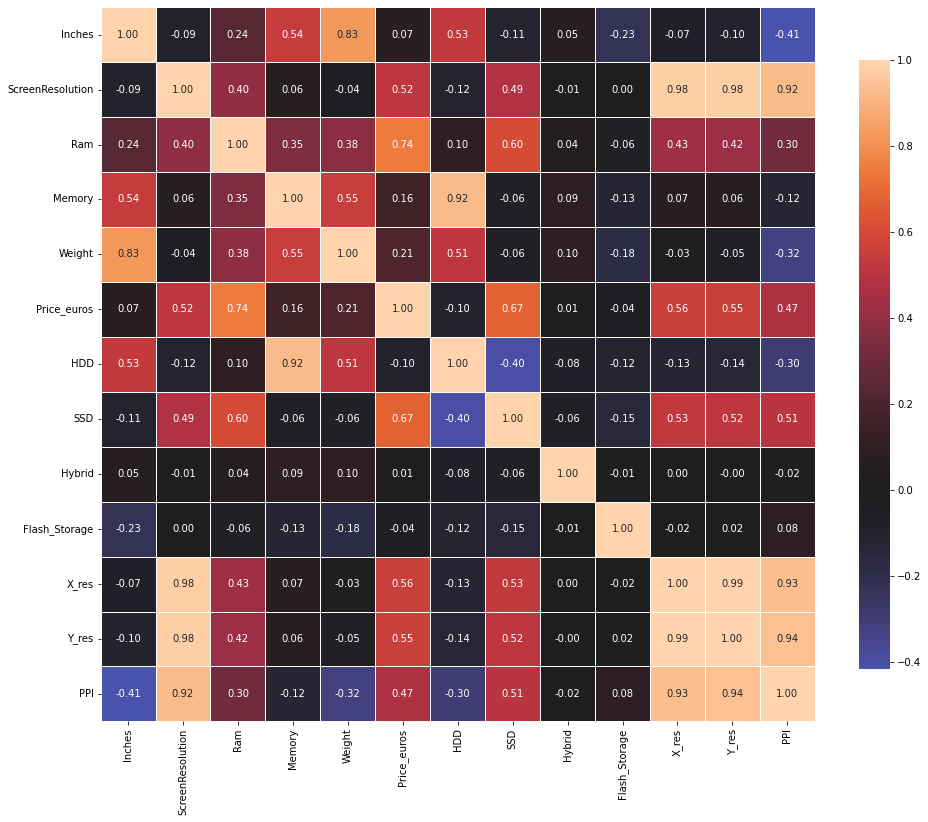

In [18]:
#Коррелляционный анализ
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(16,16))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink":.70})
    plt.show()
correlation_heatmap(laptops)

In [52]:
print('Признаки, имеющие максимальную по модулю корреляцию с ценой ноутбука')
best_params = laptops.corr()['Price_euros'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.35]
best_params

Признаки, имеющие максимальную по модулю корреляцию с ценой ноутбука


Ram                 0.743007
SSD                 0.670799
X_res               0.556529
Y_res               0.552809
ScreenResolution    0.515486
PPI                 0.473487
Name: Price_euros, dtype: float64

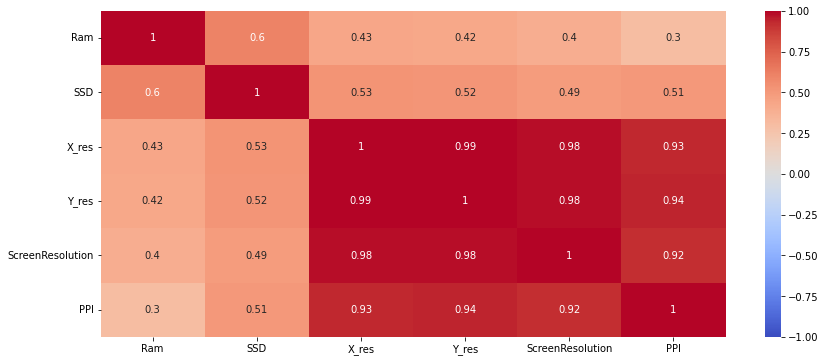

In [53]:
plt.figure(figsize=(14, 6))
sns.heatmap(laptops[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

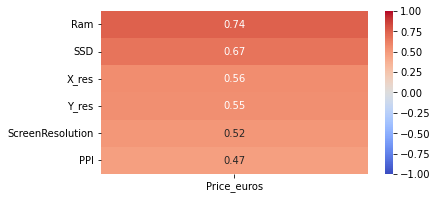

In [54]:
plt.figure(figsize=(6, 3))
sns.heatmap(pd.DataFrame(laptops[np.append(best_params.index.values, 'Price_euros')].corr()['Price_euros'].sort_values(ascending=False)[1:]), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

In [55]:
#Разделение выборки на обучающую и тестовую
y = laptops['Price_euros']
X = laptops[best_params.index]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)


In [56]:
# Линейная регрессия
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [57]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred_linear = linear_model.predict(x_test)
print_metrics(y_test, y_pred_linear)

R^2: 0.6379618338689471
MSE: 173054.05014963986
MAE: 310.74275166816795


In [58]:
# Полиномиальная регрессия
poly_model = PolynomialFeatures(degree=3)
x_train_poly = poly_model.fit_transform(x_train)
x_test_poly = poly_model.fit_transform(x_test)
linear_model = LinearRegression()
linear_model.fit(x_train_poly, y_train)
y_pred_poly = linear_model.predict(x_test_poly)
print_metrics(y_test, y_pred_poly)

R^2: 0.5805735881665712
MSE: 200485.6009607326
MAE: 321.6871983456285


In [59]:
# SVM
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train_scaled.describe()

,Ram,SSD,X_res,Y_res,ScreenResolution,PPI
count,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02
mean,-6.232831e-17,-3.505967e-17,-2.337312e-17,3.544923e-16,1.636118e-16,-4.869399e-16
std,1.000549e+00,1.000549e+00,1.000549e+00,1.000549e+00,1.000549e+00,1.000549e+00
min,-1.225851e+00,-9.940405e-01,-1.098077e+00,-1.093414e+00,-8.232087e-01,-1.360108e+00
25%,-8.379344e-01,-9.940405e-01,6.651269e-02,4.906480e-02,-5.244409e-02,-4.562425e-01
50%,-6.210072e-02,-1.306453e-01,6.651269e-02,4.906480e-02,-5.244409e-02,-1.149758e-01
75%,-6.210072e-02,4.412138e-01,6.651269e-02,4.906480e-02,-5.244409e-02,2.819260e-01
max,1.079957e+01,4.612422e+00,4.102636e+00,4.003800e+00,4.627611e+00,5.080469e+00


In [60]:
# Дерево решений
params = {'C': np.concatenate([np.arange(0.1, 2, 0.1), np.arange(2, 15, 1)])}
svm_model = SVR(kernel='linear')
grid_cv = GridSearchCV(estimator=svm_model, param_grid=params, cv=10, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train_scaled, y_train)
print(grid_cv.best_params_)

{'C': 14.0}


In [61]:
best_svm_model = grid_cv.best_estimator_
best_svm_model = SVR(kernel='linear', C=11)
best_svm_model.fit(x_train_scaled, y_train)
y_pred_svm = best_svm_model.predict(x_test_scaled)
print_metrics(y_test, y_pred_svm)

R^2: 0.6238423995737965
MSE: 179803.13220557166
MAE: 307.8229552113887


In [62]:
params = {'min_samples_leaf': range(3, 30)}
tree = DecisionTreeRegressor(random_state=3)
grid_cv = GridSearchCV(estimator=tree, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'min_samples_leaf': 4}


In [63]:
best_tree = grid_cv.best_estimator_
best_tree.fit(x_train, y_train)
y_pred_tree = best_tree.predict(x_test)
print_metrics(y_test, y_pred_tree)

R^2: 0.6789652616590819
MSE: 153454.4335541549
MAE: 284.90609115308723


In [64]:
importances = pd.DataFrame(data=zip(x_train.columns, best_tree.feature_importances_), columns=['Признак', 'Важность'])
print('Важность признаков в дереве решений\n')
for row in importances.sort_values(by='Важность', ascending=False).values:
    print(f'{row[0]}: {round(row[1], 3)}')

Важность признаков в дереве решений

Ram: 0.784
PPI: 0.098
SSD: 0.087
ScreenResolution: 0.022
X_res: 0.009
Y_res: 0.0


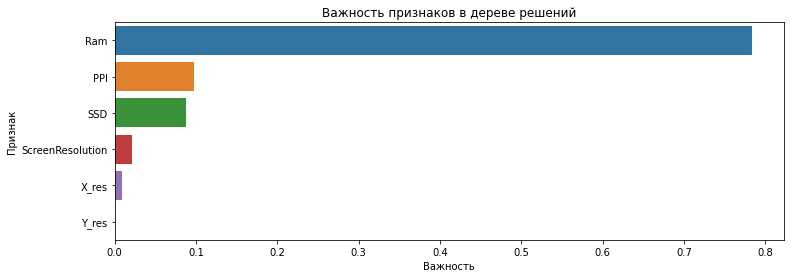

In [65]:
plt.figure(figsize=(12, 4))
sns.barplot(data=importances.sort_values(by='Важность', ascending=False), y='Признак', x='Важность', orient='h', )
plt.title('Важность признаков в дереве решений')
plt.show()

In [71]:
#Сравнение моделей
print('Линейная регрессия')
print_metrics(y_test, y_pred_linear)

print('\nПолиномиальная регрессия')
print_metrics(y_test, y_pred_poly)

print('\nМетод опорных векторов')
print_metrics(y_test, y_pred_svm)

print('\nДерево решений')
print_metrics(y_test, y_pred_tree)

Линейная регрессия
R^2: 0.6379618338689471
MSE: 173054.05014963986
MAE: 310.74275166816795

Полиномиальная регрессия
R^2: 0.5805735881665712
MSE: 200485.6009607326
MAE: 321.6871983456285

Метод опорных векторов
R^2: 0.6238423995737965
MSE: 179803.13220557166
MAE: 307.8229552113887

Дерево решений
R^2: 0.6789652616590819
MSE: 153454.4335541549
MAE: 284.90609115308723
